## Importing libraries and Loading the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import gc

# Load the data
df = pd.read_csv('final_count_matrix.csv')

# Mapping of Ensembl IDs to gene names
ensembl_to_gene = {
    'ENSG00000108405': 'P2RX1',
    'ENSG00000187848': 'P2RX2',
    'ENSG00000109991': 'P2RX3',
    'ENSG00000135124': 'P2RX4',
    'ENSG00000083454': 'P2RX5',
    'ENSG00000099957': 'P2RX6',
    'ENSG00000089041': 'P2RX7'
}

p2x_genes = ['P2RX1', 'P2RX2', 'P2RX3', 'P2RX4', 'P2RX5', 'P2RX6', 'P2RX7']

# Rename columns using the mapping
df.rename(columns=ensembl_to_gene, inplace=True)

# Display the first few rows to understand the structure
df.head()

,V1,P2RX1,P2RX2,P2RX3,P2RX4,P2RX5,P2RX6,P2RX7
0,AAACCCAGTCGCATGC-1_1_70543c0e-3414-40e2-9817-c...,0.466845,0.0,NaN,0.466845,0.000000,0.0,0.783860
1,AAAGAACCATACAGGG-1_1_70543c0e-3414-40e2-9817-c...,0.615174,0.0,NaN,0.000000,0.000000,0.0,0.615174
2,AAAGGATAGAAGGCTC-1_1_70543c0e-3414-40e2-9817-c...,1.097547,0.0,NaN,1.608159,1.097547,0.0,0.000000
3,AAAGGATTCCCTATTA-1_1_70543c0e-3414-40e2-9817-c...,0.000000,0.0,NaN,0.991687,0.000000,0.0,1.806210
4,AAAGGGCAGTCTAGCT-1_1_70543c0e-3414-40e2-9817-c...,0.000000,0.0,NaN,0.000000,0.000000,0.0,1.711862


# Exploratory Data Analysis (EDA)

## Initial Summary statistics for P2X genes (before filtering corrupted datasets)

In [2]:
# Calculate basic statistics for each P2X gene
summary_stats = df.describe()
summary_stats

,P2RX1,P2RX2,P2RX3,P2RX4,P2RX5,P2RX6,P2RX7
count,1.301523e+07,1.214519e+07,1.218244e+07,1.290201e+07,1.272813e+07,1.286678e+07,1.290201e+07
mean,1.116747e-01,-2.473234e-03,1.758498e-02,5.025990e-01,1.452820e-01,1.218194e-01,1.028246e+00
std,1.495296e+00,7.811368e-01,8.085884e-01,5.011892e+00,2.180863e+00,2.326592e+00,1.064080e+01
min,-6.942288e+00,-6.942288e+00,-4.749713e-03,-6.942288e+00,-6.942288e+00,-6.942288e+00,-6.942288e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00,0.000000e+00,5.625674e-01,0.000000e+00,0.000000e+00,1.000000e+00
max,2.305000e+03,5.450000e+02,6.070000e+02,2.501000e+03,9.480000e+02,2.408000e+03,5.510000e+03


## Investigating and correcting negative values in the data

In [3]:
# Count the number of negative values for each gene
negative_counts = (df.iloc[:, 1:] < 0).sum()
negative_counts

P2RX1     503693
P2RX2     494287
P2RX3     457954
P2RX4     491945
P2RX5    1711893
P2RX6     504755
P2RX7     500764
dtype: int64

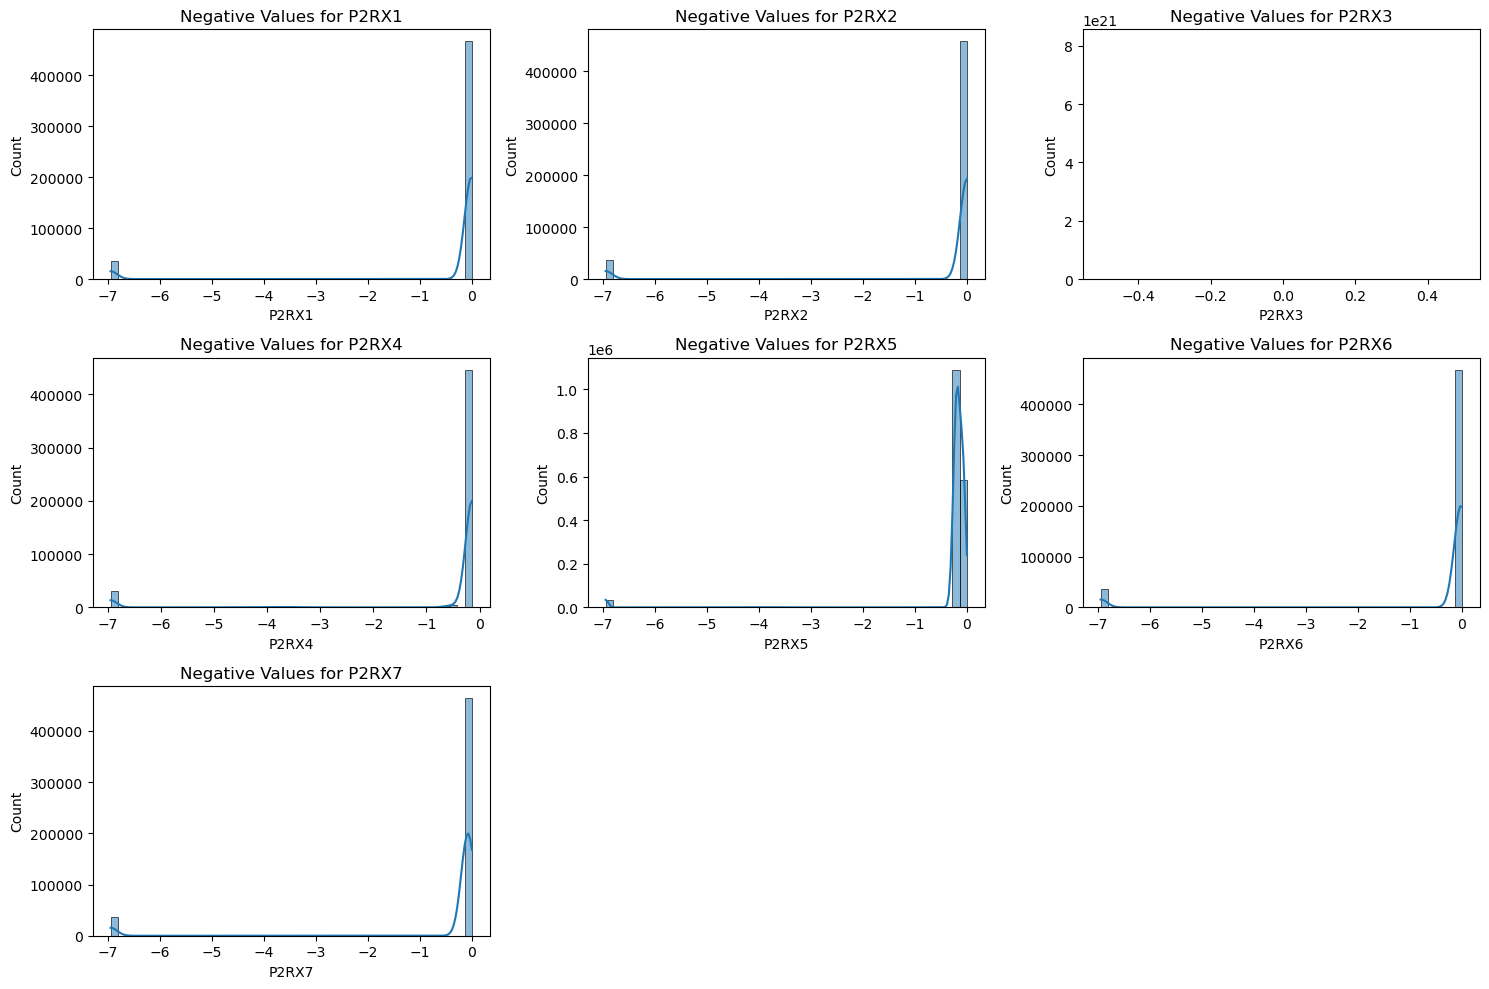

In [4]:
# Explore the distribution of negative values for each gene
plt.figure(figsize=(15, 10))
for idx, gene in enumerate(ensembl_to_gene.values()):
    plt.subplot(3, 3, idx + 1)
    sns.histplot(df[gene][df[gene] < 0], bins=50, kde=True)
    plt.title(f'Negative Values for {gene}')
plt.tight_layout()
plt.show()

In [5]:
# Get cells with any negative values
negative_values_df = df[df.iloc[:, 1:].apply(lambda x: any(x < 0), axis=1)]
negative_values_df.head()

,V1,P2RX1,P2RX2,P2RX3,P2RX4,P2RX5,P2RX6,P2RX7
487715,AAACCTGAGTAATCCC-1_1_0cf05592-3267-4964-82a5-c...,-6.942288,-6.942288,0.0,-6.942288,-6.942288,-6.942288,-6.942288
487716,AAACCTGGTCAATGTC-1_1_0cf05592-3267-4964-82a5-c...,-6.942288,-6.942288,0.0,-6.942288,-6.942288,-6.942288,-6.942288
487717,AAACCTGTCTGTACGA-1_1_0cf05592-3267-4964-82a5-c...,-4.784394,-6.942288,0.0,-6.942288,-6.942288,-6.942288,-6.942288
487718,AAACGGGAGTTAACGA-1_1_0cf05592-3267-4964-82a5-c...,-6.942288,-6.942288,0.0,-6.942288,-6.942288,-6.942288,-6.942288
487719,AAACGGGCAACACCTA-1_1_0cf05592-3267-4964-82a5-c...,-6.942288,-6.942288,0.0,-6.942288,-6.942288,-6.942288,-6.942288


In [6]:
# Define the function to extract dataset ID
def extract_dataset_id(cell_name):
    match = re.search(r'_([^_]+)_p2x_filtered$', cell_name)
    return match.group(1) if match else None

# If the cell IDs are not in the index but in a specific column, for example, 'cell_id'
cell_ids = negative_values_df.iloc[:, 0]  # the 'cell_id' is the first column

# Extract dataset IDs from the cell names
dataset_ids = cell_ids.apply(extract_dataset_id)

# Get unique dataset IDs and their counts
unique_dataset_ids = dataset_ids.value_counts()

# Print out the unique dataset IDs and their counts
print("Unique dataset IDs with negative values and their counts:")
print(unique_dataset_ids)

Unique dataset IDs with negative values and their counts:
V1
cece7dd6-cad7-450d-8b1c-841d49552cea    1213081
b3d20a90-5b30-4ac8-8344-1c56ea1cf06f     457965
0cf05592-3267-4964-82a5-c98b3dac02ed      36325
b1ff0e05-486e-4569-92c7-d9100c833a03      12496
Name: count, dtype: int64


### 4 datasets are causing this problem and are mostly corrupt, to correct this it is best to filter out all cells of these datasets.

In [7]:
# Convert the index of the unique dataset IDs to a set for faster lookup
unique_dataset_ids_set = set(unique_dataset_ids.index)

# Function to check if a cell belongs to any of the datasets 
def belongs_to_dataset(cell_name):
    dataset_id = extract_dataset_id(cell_name)
    return dataset_id in unique_dataset_ids_set

# Apply the function to filter out cells from these datasets
filtered_df = df[~df.iloc[:, 0].apply(belongs_to_dataset)]

# Display the shape of the original and filtered DataFrames to understand how many cells were removed
print(f"Original DataFrame shape: {df.shape}")
print(f"Filtered DataFrame shape: {filtered_df.shape}")

Original DataFrame shape: (13017546, 8)
Filtered DataFrame shape: (11247068, 8)


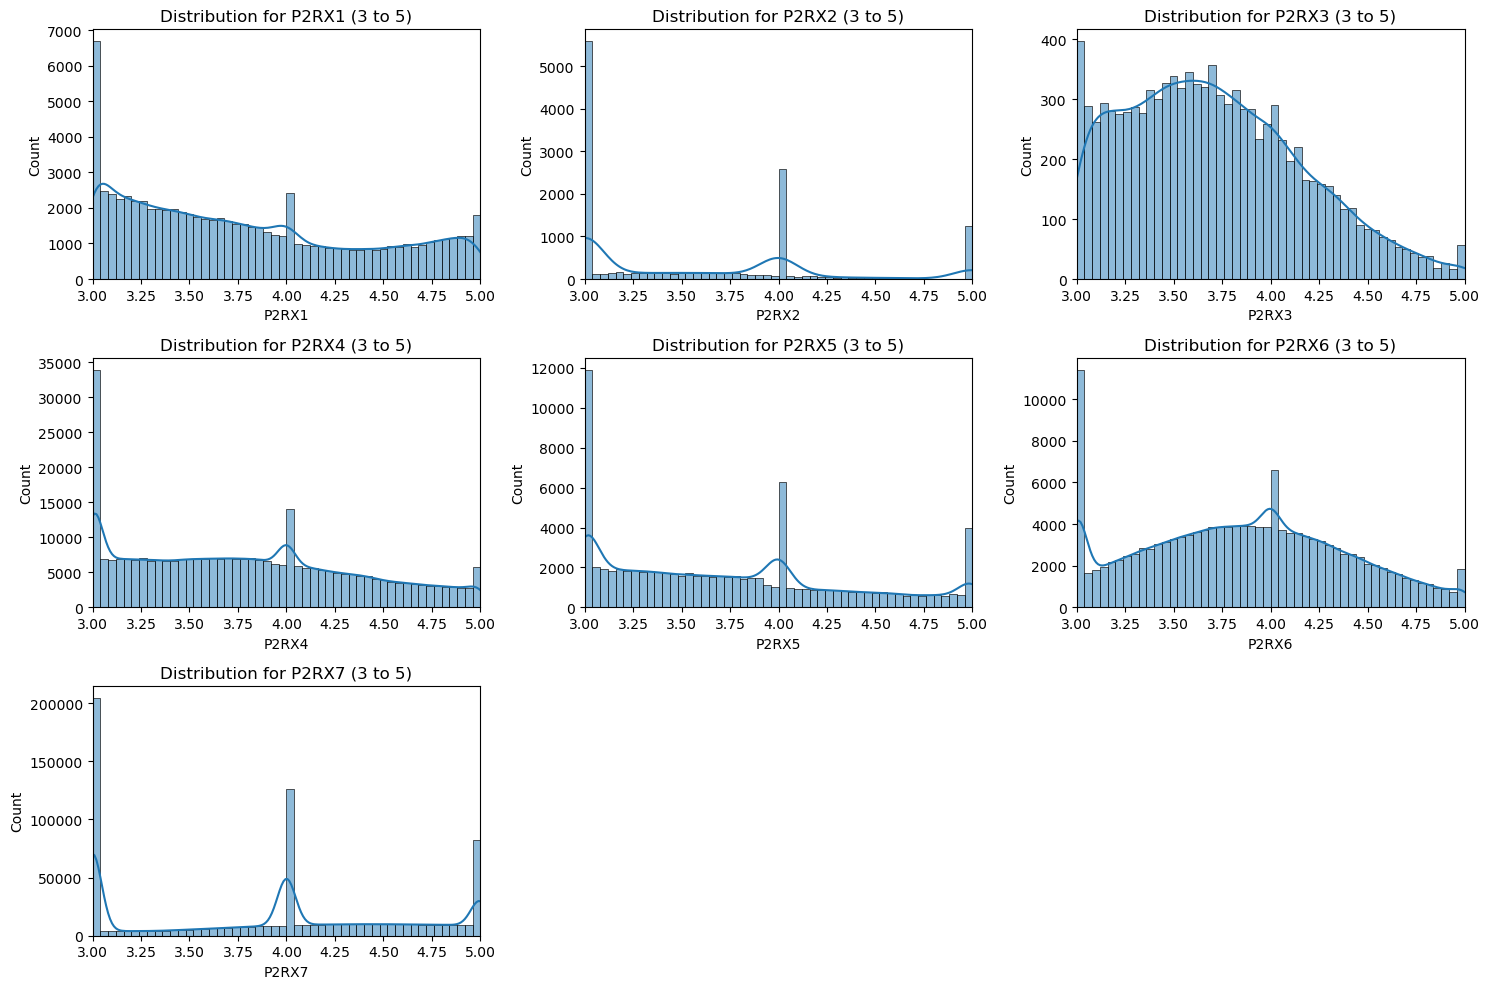

In [8]:
# Explore the distribution of values between 0 and 5 for each gene
plt.figure(figsize=(15, 10))
for idx, gene in enumerate(ensembl_to_gene.values()):
    plt.subplot(3, 3, idx + 1)
    sns.histplot(filtered_df[gene][(filtered_df[gene] >= 3) & (filtered_df[gene] <= 5)], bins=50, kde=True)
    plt.title(f'Distribution for {gene} (3 to 5)')
    plt.xlim(3, 5)
plt.tight_layout()
plt.show()

## Clean up memory

In [9]:
del df, negative_counts, negative_values_df, cell_ids, dataset_ids, unique_dataset_ids, unique_dataset_ids_set
gc.collect()

37561

## Corrected Summary statistics for P2X genes (after filtering negative datasets)

In [10]:
# Calculate basic statistics for each P2X gene
summary_stats = filtered_df.describe()
summary_stats

,P2RX1,P2RX2,P2RX3,P2RX4,P2RX5,P2RX6,P2RX7
count,1.124475e+07,1.038723e+07,1.042447e+07,1.113154e+07,1.095765e+07,1.109631e+07,1.113154e+07
mean,1.519801e-01,2.148608e-02,2.074859e-02,6.035767e-01,1.918680e-01,1.646029e-01,1.215040e+00
std,1.556629e+00,7.378935e-01,8.740125e-01,5.372577e+00,2.286732e+00,2.470977e+00,1.143701e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.634542e-01
75%,0.000000e+00,0.000000e+00,0.000000e+00,7.133490e-01,0.000000e+00,0.000000e+00,1.075386e+00
max,2.305000e+03,5.450000e+02,6.070000e+02,2.501000e+03,9.480000e+02,2.408000e+03,5.510000e+03


The removal of datasets with negative values appears to have corrected the issue, resulting in more accurate summary statistics.

## Removal of Noisy Ultra-low Expression Values (excluding zero)

This allows for removal of noise due to ultra-lowly expressed genes and provides a cleaner visualization. According to the cellxgene documentation counts less or equal than 3 are Noisy Ultra-low Expression and are set to NaN values. However, Given that zero values can indicate true lack of expression and are biologically significant, it is better to keep them as zeros.

In [11]:

# Define the function to replace ultra-low expression values with NaN, excluding zero
def replace_ultra_low_with_nan(x):
    if 0 < x <= 3:
        return np.nan
    else:
        return x

# Apply the function to the DataFrame
filtered_df.iloc[:, 1:] = filtered_df.iloc[:, 1:].applymap(replace_ultra_low_with_nan)

# Verify the changes by displaying the first few rows
filtered_df.head()


/local/bmsas1/ipykernel_3079285/3012977754.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  filtered_df.iloc[:, 1:] = filtered_df.iloc[:, 1:].applymap(replace_ultra_low_with_nan)


,V1,P2RX1,P2RX2,P2RX3,P2RX4,P2RX5,P2RX6,P2RX7
0,AAACCCAGTCGCATGC-1_1_70543c0e-3414-40e2-9817-c...,NaN,0.0,NaN,NaN,0.0,0.0,NaN
1,AAAGAACCATACAGGG-1_1_70543c0e-3414-40e2-9817-c...,NaN,0.0,NaN,0.0,0.0,0.0,NaN
2,AAAGGATAGAAGGCTC-1_1_70543c0e-3414-40e2-9817-c...,NaN,0.0,NaN,NaN,NaN,0.0,0.0
3,AAAGGATTCCCTATTA-1_1_70543c0e-3414-40e2-9817-c...,0.0,0.0,NaN,NaN,0.0,0.0,NaN
4,AAAGGGCAGTCTAGCT-1_1_70543c0e-3414-40e2-9817-c...,0.0,0.0,NaN,0.0,0.0,0.0,NaN


## Identify and Drop Samples with All Zeros or NaNs

In [12]:
# Define a function to identify rows where all P2X gene expressions are 0 or NaN
def is_all_zero_or_nan(row):
    return all((pd.isna(x) or x == 0) for x in row)

# Apply the function to filter out these rows
filtered_df = filtered_df[~filtered_df[p2x_genes].apply(is_all_zero_or_nan, axis=1)]

# Verify by displaying the shape of the DataFrame
print(f"Filtered DataFrame shape after removing all-zero/NaN samples: {filtered_df.shape}")

Filtered DataFrame shape after removing all-zero/NaN samples: (1502167, 8)


## The percentage of non-zero expression and non-NaN expression for each gene

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


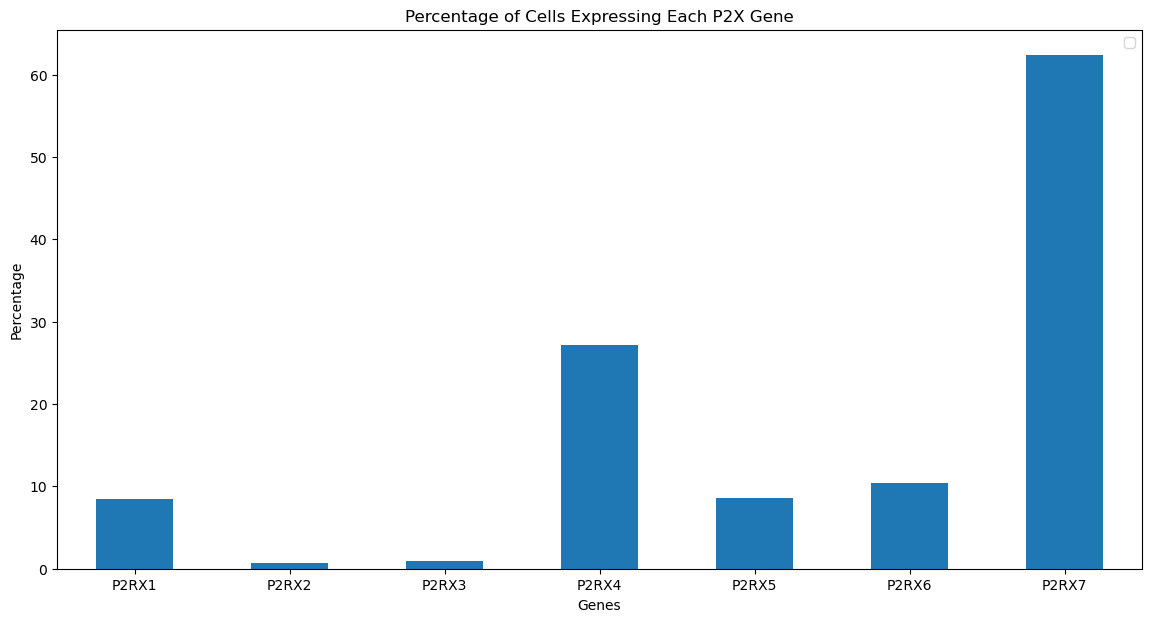

In [13]:
# The first column is cell IDs
p2x_genes = filtered_df.columns[1:]

# Calculate the percentage of non-zero for each gene
non_zero_expression = (filtered_df[p2x_genes] > 0).sum() / len(filtered_df) * 100

# Plot the percentage of non-zero and non-NaN expression
plt.figure(figsize=(14, 7))
non_zero_expression.plot(kind='bar', figsize=(14, 7))
plt.title('Percentage of Cells Expressing Each P2X Gene')
plt.xlabel('Genes')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.legend(loc='best')
plt.show()

## Percentage of NaN Values for Each P2X Gene

P2RX1     1.232952
P2RX2    11.757082
P2RX3    10.479660
P2RX4     8.017817
P2RX5     5.427759
P2RX6     3.381914
P2RX7     1.003950
dtype: float64


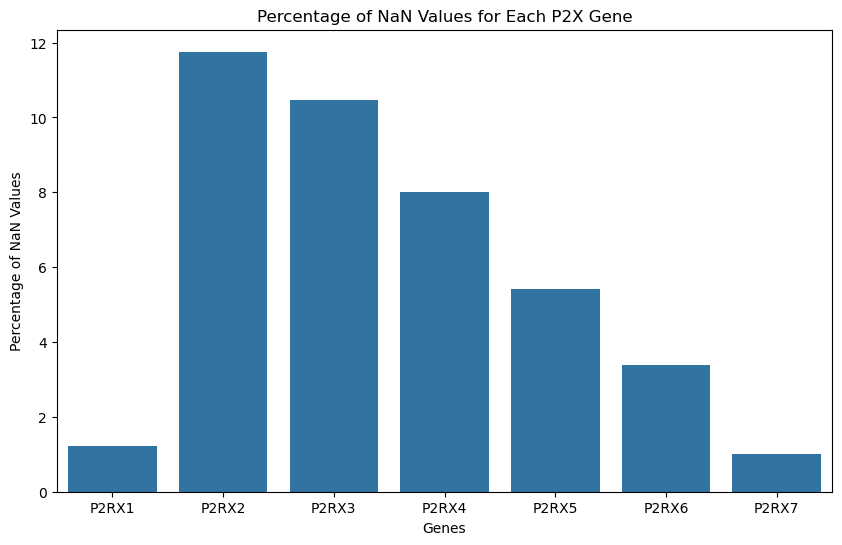

In [14]:
# Calculate the percentage of NaN values for each gene
nan_percentage = filtered_df[p2x_genes].isna().sum() / len(filtered_df) * 100

# Print the percentage of NaN values
print(nan_percentage)

# Plot the percentage of NaN values
plt.figure(figsize=(10, 6))
sns.barplot(x=nan_percentage.index, y=nan_percentage.values)
plt.title('Percentage of NaN Values for Each P2X Gene')
plt.xlabel('Genes')
plt.ylabel('Percentage of NaN Values')
plt.xticks(rotation=0)
plt.show()

## Additional plots

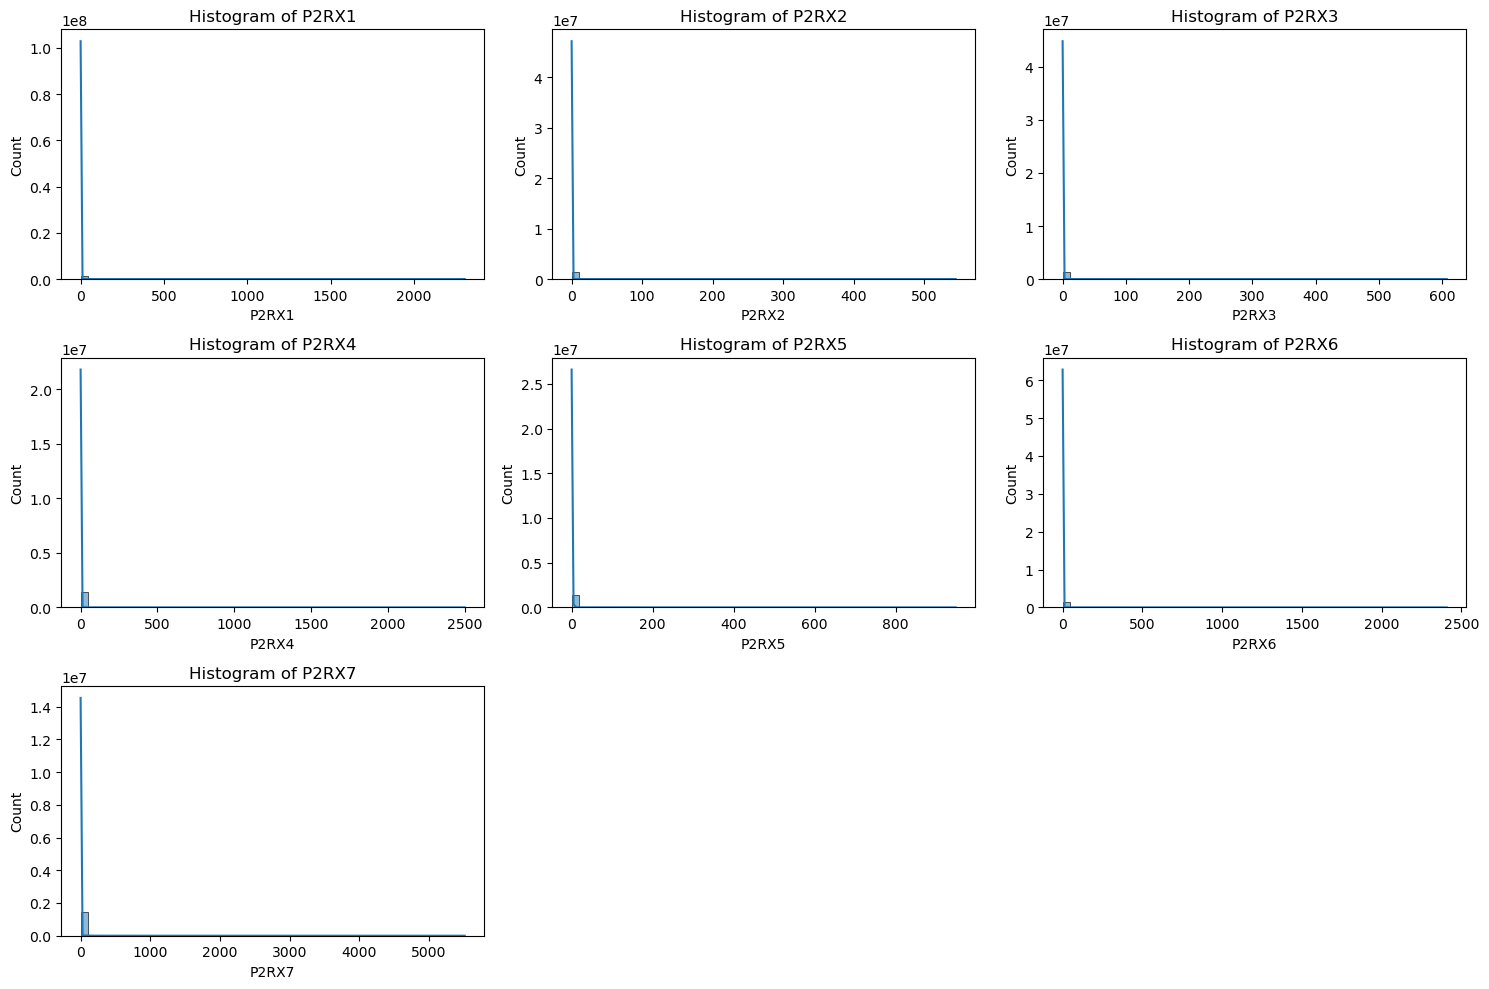

In [15]:
# Plot histograms for the expression levels of each P2X gene
plt.figure(figsize=(15, 10))
for idx, gene in enumerate(filtered_df.columns[1:]): 
    plt.subplot(3, 3, idx + 1)
    sns.histplot(filtered_df[gene], bins=50, kde=True)
    plt.title(f'Histogram of {gene}')
plt.tight_layout()
plt.show()

Low Expression in Majority: Most cells have zero or very low expression for all P2X genes.

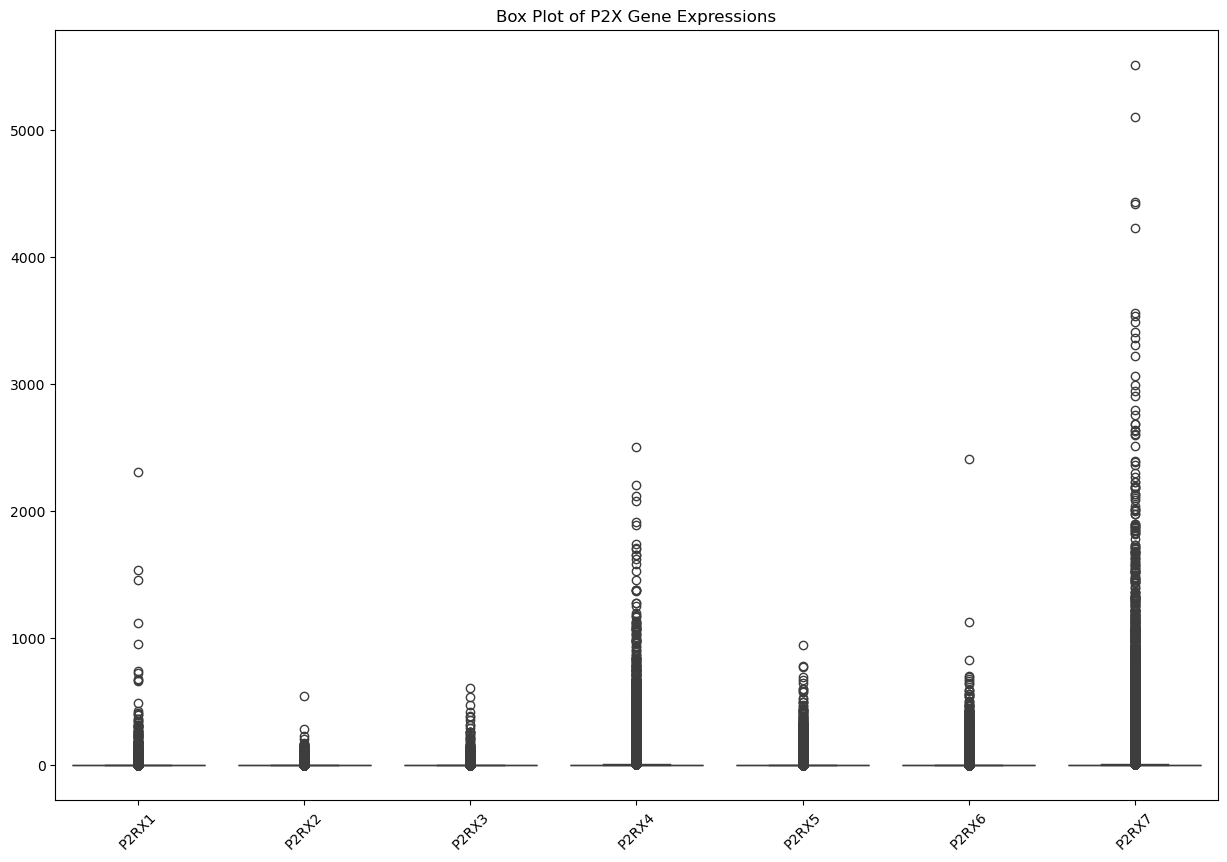

In [16]:
# Plot box plots for the expression levels of each P2X gene
plt.figure(figsize=(15, 10))
sns.boxplot(data=filtered_df.iloc[:, 1:])  # Exclude the first column (cell IDs)
plt.title('Box Plot of P2X Gene Expressions')
plt.xticks(rotation=45)
plt.show()

Presence of High Expressors: There are some cells with very high expression, especially for P2RX7, as indicated by the outliers in the box plot.

## Identifying cells with extremely high expression values

In [17]:
# Identify cells with extremely high expression values for P2RX7
high_expressors = filtered_df[filtered_df['P2RX7'] > 5000]
print("Cells with extremely high P2RX7 expression:")
print(high_expressors)

Cells with extremely high P2RX7 expression:
                                                        V1  P2RX1  P2RX2  \
5080882  F2S4_170531_020_H01_77a91ab6-4fcc-428d-b719-a3...    0.0    0.0   
5080992  F2S4_170531_002_H01_77a91ab6-4fcc-428d-b719-a3...    0.0    0.0   

         P2RX3   P2RX4  P2RX5  P2RX6   P2RX7  
5080882    0.0     NaN    0.0    0.0  5104.0  
5080992    0.0  1375.0    0.0    0.0  5510.0  


## Save the filtered DataFrame to a new CSV file

In [18]:
# Save the filtered DataFrame to a new CSV file (if needed)
filtered_df.to_csv('filtered_final_count_matrix.csv', index=False)

# Co-expression Analysis

## Pairwise Co-expression Analysis

### Pearson Correlation

In [ ]:
# Calculate pairwise correlation coefficients between P2X genes
correlation_matrix = filtered_df.iloc[:, 1:].corr(method='pearson')

# Visualize these correlations using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', xticklabels=ensembl_to_gene.values(), yticklabels=p2x_genes)
plt.title('Pairwise P2X Gene Co-expression (Pearson)')
plt.show()

- Some Strong Correlations: The heatmap shows that there are some strong positive correlations between the P2X genes.
- Pearson correlation is sensitive to outliers but might not capture the co-expression well when the majority of the data is near zero, but when we removed the Noisy Ultra-low Expression Values it gave better expression now.
- The sparsity of the data (many zeros) reduces the likelihood of finding strong linear correlations between the genes.

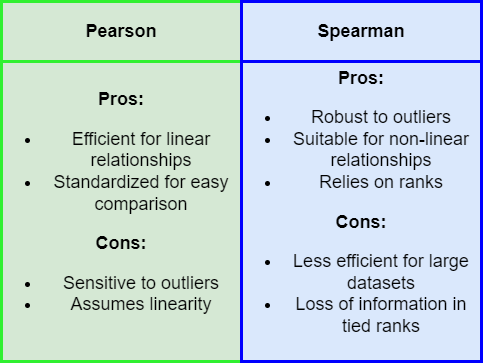

## Spearman Correlation Analysis

In [ ]:
# Calculate Spearman correlation coefficients between P2X genes
spearman_correlation_matrix = filtered_df[p2x_genes].corr(method='spearman')

# Visualize these correlations using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(spearman_correlation_matrix, annot=True, cmap='coolwarm', xticklabels=p2x_genes, yticklabels=p2x_genes)
plt.title('Pairwise P2X Gene Co-expression (Spearman)')
plt.show()

In [ ]:
# Subset the data to include only cells that express P2RX4 and P2RX7
subset_df = filtered_df[['P2RX4', 'P2RX7']].dropna()

# Verify the subset DataFrame
print(f"Subset DataFrame shape: {subset_df.shape}")
subset_df

In [ ]:
# Calculate Spearman correlation coefficients between P2RX4 and P2RX7
spearman_correlation_matrix = subset_df.corr(method='spearman')

# Visualize these correlations using a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(spearman_correlation_matrix, annot=True, cmap='coolwarm', xticklabels=subset_df.columns, yticklabels=subset_df.columns)
plt.title('Spearman Correlation Between P2RX4 and P2RX7')
plt.show()

In [ ]:
from sklearn.decomposition import PCA

# Perform PCA to visualize co-expression patterns in lower-dimensional space
pca = PCA(n_components=2)
pca_result = pca.fit_transform(subset_df.dropna())
subset_df['pca-one'] = pca_result[:, 0]
subset_df['pca-two'] = pca_result[:, 1]

# Scatter plot of PCA results
plt.figure(figsize=(10, 8))
sns.scatterplot(x='pca-one', y='pca-two', data=subset_df, alpha=0.5)
plt.title('PCA of P2X Gene Expression (P2RX4 and P2RX7)')
plt.show()

# Subset Analysis

In [ ]:
# Restart the kernel
#IPython.display.display(IPython.display.Javascript('IPython.notebook.kernel.restart()'))

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

# Load the metadata file
metadata = pd.read_csv('combined_metadata.csv')

# Load the filtered count matrix
#filtered_df = pd.read_csv('filtered_final_count_matrix.csv')

# Display the first few rows of each to understand their structure
metadata.head()

In [ ]:
# Define the function to extract sample ID
def extract_sample_id(cell_name):
    return re.sub(r'_[^_]+_p2x_filtered$', '', cell_name)

# Extract sample IDs from cell names in the filtered count matrix
filtered_df['sample_id'] = filtered_df.iloc[:, 0].apply(extract_sample_id)

# Display the first few rows to verify the addition of sample IDs
filtered_df.head()

In [ ]:
# Merge metadata with the filtered count matrix on the sample ID
merged_df = pd.merge(filtered_df, metadata, left_on='sample_id', right_on='sample', how='left')

# Display the first few rows to verify the merge
merged_df.head()

In [ ]:
# Define a function to perform co-expression analysis and plot heatmap
def plot_coexpression_heatmap(df, title):
    correlation_matrix = df.corr(method='pearson')
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', xticklabels=p2x_genes, yticklabels=p2x_genes)
    plt.title(title)
    plt.show()

# List of P2X genes
p2x_genes = ['P2RX1', 'P2RX2', 'P2RX3', 'P2RX4', 'P2RX5', 'P2RX6', 'P2RX7']

# Iterate over unique tissue_ontology_term_id and perform co-expression analysis
for tissue_id in merged_df['tissue_ontology_term_id'].unique():
    subset_df = merged_df[merged_df['tissue_ontology_term_id'] == tissue_id]
    if not subset_df.empty:
        subset_expression = subset_df[p2x_genes]
        plot_coexpression_heatmap(subset_expression, f'Co-expression in Tissue {tissue_id}')

In [ ]:
from scipy.stats import pearsonr
from scipy.stats import ConstantInputWarning
import warnings

# List of P2X genes
p2x_genes = ['P2RX1', 'P2RX2', 'P2RX3', 'P2RX4', 'P2RX5', 'P2RX6', 'P2RX7']

# Define a function to calculate correlation and p-value along with count of non-NaN values
def calculate_correlation_and_pvalue(df, genes):
    results = []
    for i in range(len(genes)):
        for j in range(i + 1, len(genes)):
            gene1 = genes[i]
            gene2 = genes[j]
            if gene1 in df.columns and gene2 in df.columns:
                # Drop NaN values for both genes
                valid_data = df[[gene1, gene2]].dropna()
                count = len(valid_data)
                if count > 1:  # Ensure there are at least 2 valid data points
                    corr, p_value = pearsonr(valid_data[gene1], valid_data[gene2])
                    results.append((gene1, gene2, corr, p_value, count))
    return results

# Suppress ConstantInputWarning warnings from scipy.stats
warnings.filterwarnings('ignore', category=ConstantInputWarning)

# Iterate over unique tissue_ontology_term_id and perform co-expression analysis
for tissue_id in merged_df['tissue_ontology_term_id'].unique():
    subset_df = merged_df[merged_df['tissue_ontology_term_id'] == tissue_id]
    if not subset_df.empty:
        subset_expression = subset_df[p2x_genes]
        correlations = calculate_correlation_and_pvalue(subset_expression, p2x_genes)
        
        # Print only strong positive or negative correlations
        threshold = 0.8  # Define a threshold for strong correlation
        significant_correlations = [(gene1, gene2, corr, p_value, count) for gene1, gene2, corr, p_value, count in correlations if abs(corr) >= threshold and p_value < 0.05]
        
        if significant_correlations:
            print(f"\nSignificant Correlations in Tissue {tissue_id}:")
            print(f"{'Gene1':<10} {'Gene2':<10} {'Correlation':<12} {'P-value':<10} {'Count':<5}")
            print("-" * 65)
            for gene1, gene2, corr, p_value, count in significant_correlations:
                print(f"{gene1:<10} {gene2:<10} {corr:<12.4f} {p_value:<10.4e} {count:<5}")


In [ ]:
# List of P2X genes
p2x_genes = ['P2RX1', 'P2RX2', 'P2RX3', 'P2RX4', 'P2RX5', 'P2RX6', 'P2RX7']

# Define a function to calculate correlation and p-value along with count of non-NaN values
def calculate_correlation_and_pvalue(df, genes):
    results = []
    for i in range(len(genes)):
        for j in range(i + 1, len(genes)):
            gene1 = genes[i]
            gene2 = genes[j]
            if gene1 in df.columns and gene2 in df.columns:
                # Drop NaN values for both genes
                valid_data = df[[gene1, gene2]].dropna()
                count = len(valid_data)
                if count > 1:  # Ensure there are at least 2 valid data points
                    corr, p_value = pearsonr(valid_data[gene1], valid_data[gene2])
                    results.append((gene1, gene2, corr, p_value, count))
    return results

# Suppress ConstantInputWarning warnings from scipy.stats
warnings.filterwarnings('ignore', category=ConstantInputWarning)

# Iterate over unique cell_type and perform co-expression analysis
for cell_type in merged_df['cell_type'].unique():
    subset_df = merged_df[merged_df['cell_type'] == cell_type]
    if not subset_df.empty:
        subset_expression = subset_df[p2x_genes]
        correlations = calculate_correlation_and_pvalue(subset_expression, p2x_genes)
        
        # Print only strong positive or negative correlations with count >= 100 and a p-value less than 0.5
        threshold = 0.1  # Define a threshold for strong correlation
        significant_correlations = [
            (gene1, gene2, corr, p_value, count)
            for gene1, gene2, corr, p_value, count in correlations
            if corr >= threshold and p_value < 0.05 and count >= 100 # abs(corr) to get negative correlation as well!
        ]
        
        if significant_correlations:
            print(f"\nSignificant Correlations in Cell Type {cell_type}:")
            print(f"{'Gene1':<10} {'Gene2':<10} {'Correlation':<12} {'P-value':<10} {'Count':<5}")
            print("-" * 65)
            for gene1, gene2, corr, p_value, count in significant_correlations:
                print(f"{gene1:<10} {gene2:<10} {corr:<12.4f} {p_value:<10.4e} {count:<5}")

## dorsal root ganglion (DRG) neurons is UBERON_0000044, which the P2X2 and P2X3 receptors are proven to form heterotrimers specifically in this cell type

In [ ]:
# Check if the dataset contains UBERON:0000044 in the tissue_ontology_term_id
has_uberon_0000044 = 'UBERON:0000044' in merged_df['tissue_ontology_term_id'].unique()
cell_has_uberon_0000044 = 'UBERON:0000044' in merged_df['cell_type_ontology_term_id'].unique()

# Print the result
if has_uberon_0000044:
    print("The dataset contains UBERON:0000044 in the tissue_ontology_term_id.")
else:
    print("The dataset does NOT contain UBERON:0000044 in the tissue_ontology_term_id.")

if cell_has_uberon_0000044:
    print("The dataset contains UBERON:0000044 in the cell_type_ontology_term_id.")
else:
    print("The dataset does NOT contain UBERON:0000044 in the cell_type_ontology_term_id.")

In [ ]:
# Calculate the number of unique values for each category
unique_tissue_ontology_term_id = merged_df['tissue_ontology_term_id'].nunique()
unique_cell_type_ontology_term_id = merged_df['cell_type_ontology_term_id'].nunique()
unique_cell_type = merged_df['cell_type'].nunique()

# Print the results in an organized manner
print("Unique Counts in the Dataset:")
print(f"{'Category':<30} {'Unique Count':<15}")
print("-" * 45)
print(f"{'tissue_ontology_term_id':<30} {unique_tissue_ontology_term_id:<15}")
print(f"{'cell_type_ontology_term_id':<30} {unique_cell_type_ontology_term_id:<15}")
print(f"{'cell_type':<30} {unique_cell_type:<15}")


### in the original CZ CELLxGENE dataset summary file there are 28211 distinct cell types!